In [42]:
#Importing Neccessary Libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [43]:
#Data Preprocessing

# Getting path to the root directory
data_dir = '../input/cat-and-dogs/dataset'    #the data used is https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs

# Getting path to train and test set using os.path
train_dir = os.path.join(data_dir, "training_set")
test_dir = os.path.join(data_dir, "test_set")


BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Creating a tf.data.Dataset for training and validation using the tf.keras.utils.image_dataset_from_directory utility

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                             shuffle=True,
                                                             batch_size=BATCH_SIZE,
                                                             image_size=IMG_SIZE)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


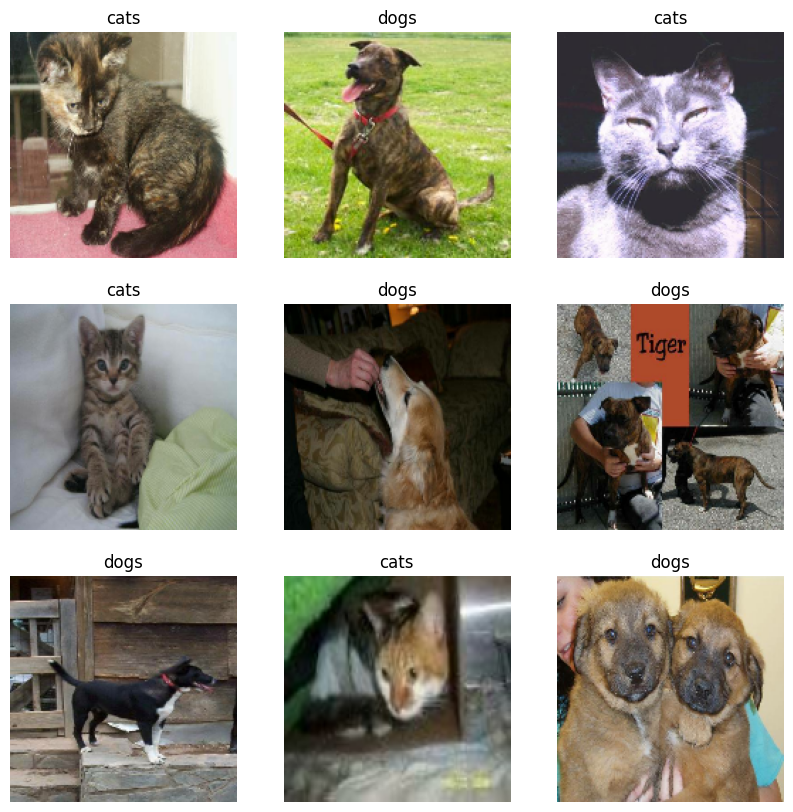

In [90]:
# Showing the first nine images and labels from the training set:

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [45]:
test_batches = tf.data.experimental.cardinality(test_dataset)
val_dataset = test_dataset.skip(test_batches // 5)
test_dataset = test_dataset.take(test_batches // 5)

In [46]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 51
Number of test batches: 12


In [47]:
#Using data augmentation

# Input by default to data_augmentation should be in the format of (batch_size, height, width, channels)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'), # 50% chance to flip the image horizontal
  tf.keras.layers.RandomRotation(0.2), # angle in radians
])

In [91]:
def compare_viz(org_img, augmented_img):
    plt.subplot(121)
    plt.imshow(org_img.numpy().astype("uint8"))
    plt.title('Original Image', color='black', weight='bold')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(augmented_img.numpy().astype("uint8"))
    plt.axis('off')
    plt.title('Augmented Image', color='royalblue', weight='bold')
    
    plt.tight_layout()
    plt.show()

In [98]:
images, labels = next(iter(train_dataset.take(1)))

first_image = images[0]
first_image_in = np.expand_dims(first_image, 0)
first_image_in.shape

(1, 160, 160, 3)

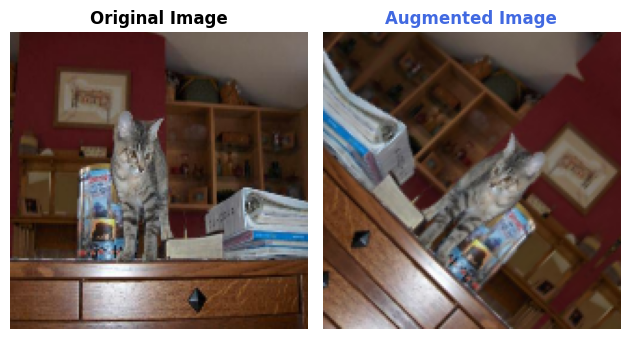

In [101]:
# 
images, labels = next(iter(train_dataset.take(1)))

first_image = images[0]
first_image_in = np.expand_dims(first_image, 0)

augmented_image = data_augmentation(first_image_in)[0]

compare_viz(first_image, augmented_image)


In [50]:
#Rescaling pixel values

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [51]:
# Create the base model from the pre-trained model MobileNet V2
'''First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet.
By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top,
which is ideal for feature extraction.'''

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features.

In [109]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [53]:
#Freezing the convolutional base

base_model.trainable = False

In [111]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [55]:
#Adding a classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [56]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [57]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [58]:
#Compiling the model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [60]:
len(model.trainable_variables)

2

In [61]:
weights = model.trainable_variables[0]
biases = model.trainable_variables[1]

print(weights)
print(weights.shape)
print(biases.shape)

# y = X.T * W + b
# (1,1) = (1, 1280) * (1280, 1) + (1,1)

<tf.Variable 'dense_1/kernel:0' shape=(1280, 1) dtype=float32, numpy=
array([[ 0.03581887],
       [ 0.06710678],
       [ 0.02519204],
       ...,
       [-0.06338393],
       [ 0.04749217],
       [-0.03107554]], dtype=float32)>
(1280, 1)
(1,)


In [62]:
#Training the model

initial_epochs = 3

loss0, accuracy0 = model.evaluate(val_dataset)

51/51 [==============================] - 4s 32ms/step - loss: 0.9088 - accuracy: 0.4567


In [63]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.91
initial accuracy: 0.46


In [64]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/3
250/250 [==============================] - 12s 34ms/step - loss: 0.6014 - accuracy: 0.6575 - val_loss: 0.2664 - val_accuracy: 0.8880
Epoch 2/3
250/250 [==============================] - 9s 34ms/step - loss: 0.2982 - accuracy: 0.8680 - val_loss: 0.1559 - val_accuracy: 0.9394
Epoch 3/3
250/250 [==============================] - 9s 34ms/step - loss: 0.2274 - accuracy: 0.9030 - val_loss: 0.1162 - val_accuracy: 0.9641


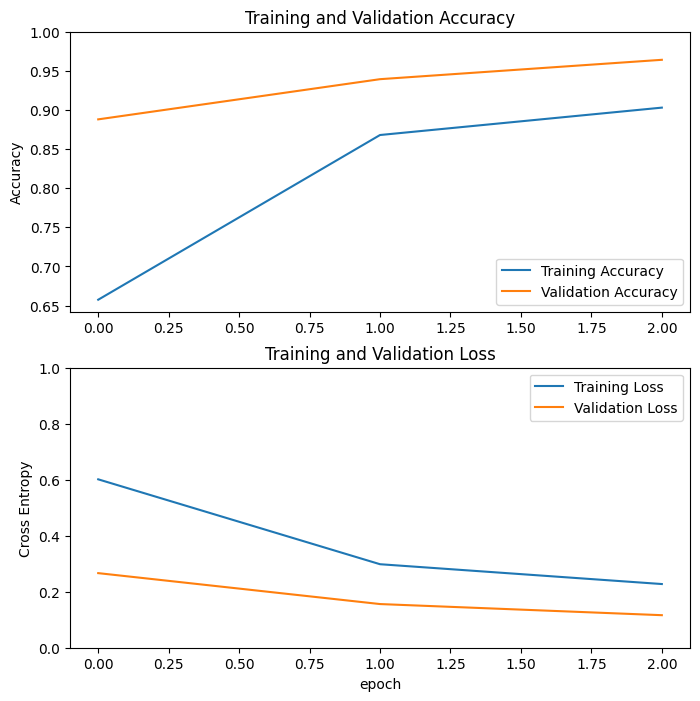

In [65]:
#Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [66]:
#Fine Tuning

#Unfreezing the top layers of the model

base_model.trainable = True

In [67]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [68]:
#Compilig the model

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [70]:
# total pairs of weights and biases that are going tp be trained
len(model.trainable_variables)

56

In [71]:
#Continue to train the model

fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 3/6
250/250 [==============================] - 23s 47ms/step - loss: 0.1275 - accuracy: 0.9499 - val_loss: 0.0515 - val_accuracy: 0.9845
Epoch 4/6
250/250 [==============================] - 11s 43ms/step - loss: 0.1006 - accuracy: 0.9596 - val_loss: 0.0426 - val_accuracy: 0.9833
Epoch 5/6
250/250 [==============================] - 11s 44ms/step - loss: 0.0946 - accuracy: 0.9615 - val_loss: 0.0360 - val_accuracy: 0.9839
Epoch 6/6
250/250 [==============================] - 11s 44ms/step - loss: 0.0850 - accuracy: 0.9670 - val_loss: 0.0366 - val_accuracy: 0.9851


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so we may get some overfitting.

We may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [72]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

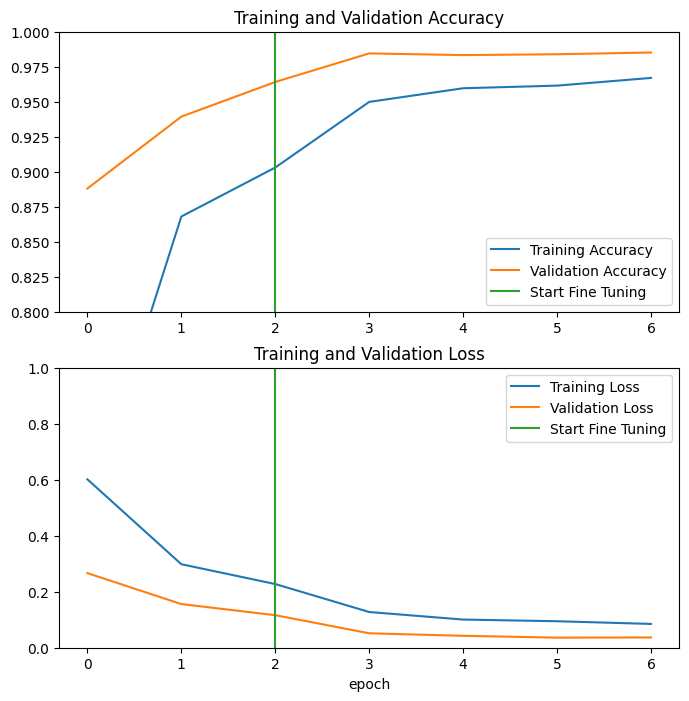

In [73]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [74]:
#Evaluation

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 0s 26ms/step - loss: 0.0516 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1]
Labels:
 [0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1]


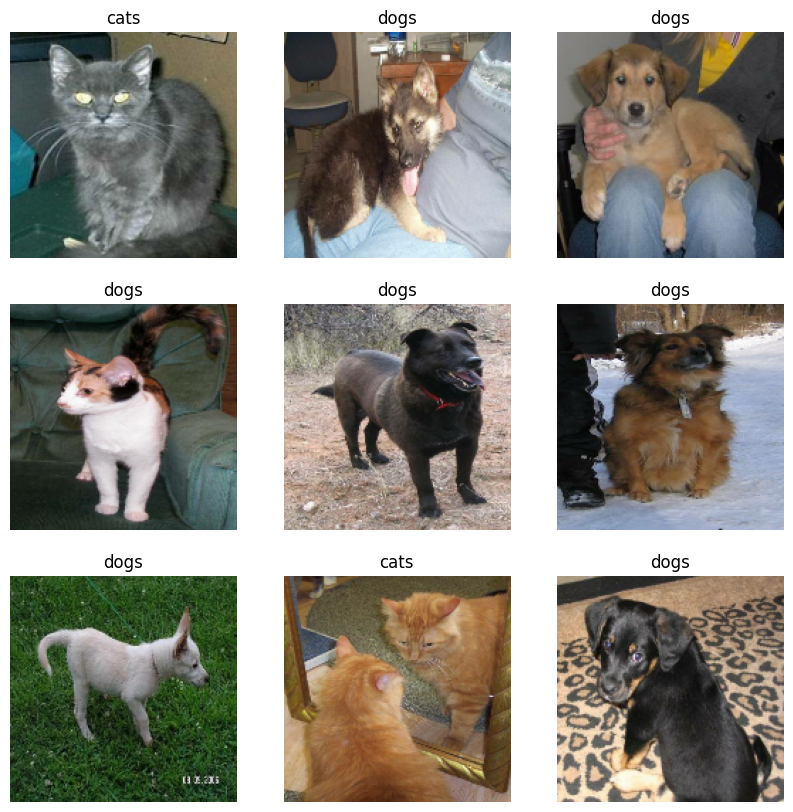

In [115]:
#Prediction

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")